In [13]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.io.wavfile
import math
import time as time_lib
class soundSimulator:
    def __init__(self):
        """the intensity is proportional to amplitude squared"""
        """the intensity is 1/distance**2"""
        """the amplitude is then inverse proportional to distance"""
        self.x_bound = [0,12]
        self.y_bound = [0,8]
        self.sample_rate = 22050
        self.dt = 1.0/22050
        #print("dt:",self.dt)
        self.fs,self.s1 = scipy.io.wavfile.read( 'data/bbibbi1.wav')#assume magnitude at 1m
        self.s1_length = len(self.s1)
        fs,self.s2 = scipy.io.wavfile.read( 'data/bbibbi2.wav')
        self.s2_length = len(self.s2)
        self.mic1_position = [0,0]
        self.mic2_position = [5,0]
        self.agent1_trajectory=[]
        self.agent2_trajectory=[]
        self.sound_speed = 343.0 #m/ss
        self.mic1 = []
        self.mic2 = []
        self.mic1_unmixed = []
        self.mic2_unmixed = []
        self.total_time = 0.0
        #print("s1 length:",len(self.s1)/self.sample_rate)
    def agentMovement(self,t):
        agent1 = [6.0+2.0*math.cos(t),6.0+2.0*math.sin(t)]
        agent2 = [6.0-5.0*math.cos(t),4.0]
        #agent1 = [0,5+3.0*t]
        #agent2 = [5,5+3.0*t]
        return agent1,agent2
        
    def simulate(self,total_time,echo = False):
        """At each simulation frame sampled at 22050, calculate when the sound from our source file will reach
        The target mic. Because it will not reach the mic at the exact sampling frame. some interpolation between 
        2 source sound point will be needed."""
        self.total_time = total_time
        total_output_N = math.ceil(total_time*self.sample_rate)
        total_input_N = total_output_N + 500 #make this a bit more then cut 
        #first calculate the times at which the input sources will arrive at the mics
        #(non-integer multiples of self.dt)
        raw_output_1_1 = []
        raw_output_1_2 = []
        raw_output_2_1 = []
        raw_output_2_2 = []
        raw_output_time_stamp_1_1_list = [] #mic1 from agent 1
        raw_output_time_stamp_1_2_list = []
        raw_output_time_stamp_2_1_list = [] #mic2 from agent 1
        raw_output_time_stamp_2_2_list = []
        final_output_time = []
        
        for i in range(total_output_N):
            time = self.dt*float(i)
            final_output_time.append(time)
        print("Generating Raw Output.....")
        time_flag_2 = time_lib.time()
        for i in range(total_input_N):
            #The code is ugly rn, maybe modify later.....
            #the sound from agent; keep repeating the sound
            sound_1 = self.s1[i%self.s1_length]
            sound_2 = self.s2[i%self.s2_length]
            #agent movement
            time = self.dt*float(i)
            agent_1,agent_2 = self.agentMovement(time)
            #print(agent_1,agent_2)
            #record agent trajectory
            self.agent1_trajectory.append(agent_1)
            self.agent2_trajectory.append(agent_2)
            ####for mic_1
            r_1_1 = np.linalg.norm(self._substract(agent_1,self.mic1_position))
            r_1_2 = np.linalg.norm(self._substract(agent_2,self.mic1_position))
            #print(r_1_1)
            sound_1_1 = sound_1/r_1_1**2#sound to mic 1 from agent 1
            sound_1_2 = sound_2/r_1_2**2
            #now the arrive time stamp...
            raw_output_time_stamp_1_1 = time + r_1_1/self.sound_speed
            raw_output_time_stamp_1_2 = time + r_1_2/self.sound_speed
            ####for mic_2
            r_2_1 = np.linalg.norm(self._substract(agent_1,self.mic2_position))
            r_2_2 = np.linalg.norm(self._substract(agent_2,self.mic2_position))
            sound_2_1 = sound_1/r_2_1**2#sound to mic 1 from agent 1
            sound_2_2 = sound_2/r_2_2**2
            #now the arrive time stamp...
            raw_output_time_stamp_2_1 = time + r_2_1/self.sound_speed
            raw_output_time_stamp_2_2 = time + r_2_2/self.sound_speed
            #append things
            raw_output_1_1.append(sound_1_1)
            raw_output_1_2.append(sound_1_2)
            raw_output_2_1.append(sound_2_1)
            raw_output_2_2.append(sound_2_2)
            raw_output_time_stamp_1_1_list.append(raw_output_time_stamp_1_1)
            raw_output_time_stamp_1_2_list.append(raw_output_time_stamp_1_2)
            raw_output_time_stamp_2_1_list.append(raw_output_time_stamp_2_1)
            raw_output_time_stamp_2_2_list.append(raw_output_time_stamp_2_2)
        #plt.plot(raw_output_1_1)
        print("Took" + " " + str(time_lib.time() - time_flag_2) + "secs to generate")
        #now interpolate to arrive at interger multiplies of dt
        print("Interpolating to get final output...")
        time_flag_2 = time_lib.time()
        adjusted_output_1_1 = self._interpolate(raw_output_1_1,raw_output_time_stamp_1_1_list,final_output_time)        
        adjusted_output_1_2 = self._interpolate(raw_output_1_2,raw_output_time_stamp_1_2_list,final_output_time)   
        adjusted_output_2_1 = self._interpolate(raw_output_2_1,raw_output_time_stamp_2_1_list,final_output_time)   
        adjusted_output_2_2 = self._interpolate(raw_output_2_2,raw_output_time_stamp_2_2_list,final_output_time)
        plt.plot(adjusted_output_1_1)
        print("Took"+ " " + str(time_lib.time() - time_flag_2) + "secs to generate")
        self.mic1 = self._add_int(adjusted_output_1_1,adjusted_output_1_2)
        self.mic1_unmixed = [adjusted_output_1_1,adjusted_output_1_2]
        self.mic2 = self._add_int(adjusted_output_2_1,adjusted_output_2_2)
        self.mic2_unmixed = [adjusted_output_2_1,adjusted_output_2_2]
        #save to disc
        scipy.io.wavfile.write('output/mic1.wav',rate = 22050 ,data = np.array(self.mic1,dtype = "int16"))
        scipy.io.wavfile.write('output/mic2.wav',rate = 22050 ,data = np.array(self.mic2,dtype = "int16"))
        print("Simulation completed, .wav files have also been rewritten to disc.")
        return 
        #scipy.io.wavfile.write('output/mic1.wav',rate =self.fs ,data = self.s1)
    
    def simulatedSound(self,t_start,t_end):
        """Return the simulated sound from mic1 and mic2"""
        assert t_start >= 0
        assert t_start < t_end
        assert t_end <= self.total_time
        start_index = math.floor(t_start/self.dt)
        end_index = math.ceil(t_end/self.dt)
        
        return self.mic1[start_index:end_index+1],self.mic2[start_index:end_index+1]
    
    def simulatedUnmixedSound(self,t_start,t_end):
        assert t_start >= 0
        assert t_start < t_end
        assert t_end <= self.total_time
        start_index = math.floor(t_start/self.dt)
        end_index = math.ceil(t_end/self.dt)
        
        return self.mic1_unmixed[0][start_index:end_index+1],\
            self.mic1_unmixed[1][start_index:end_index+1],\
            self.mic2_unmixed[0][start_index:end_index+1],\
            self.mic2_unmixed[1][start_index:end_index+1]
    
    def simulatedTrajectory(self,s_start,t_end):
        """return the true trajectories of the 2 agents"""
        assert t_start >= 0
        assert t_start < t_end
        assert t_end <= self.total_time
        start_index = math.floor(t_start/self.dt)
        end_index = math.ceil(t_end/self.dt)
        
        return self.agent1_trajectory[start_index:end_index+1],self.agent2_trajectory[start_index:end_index+1]
        
    def _substract(self,a,b):
        res = []
        for ele1,ele2 in zip(a,b):
            res.append(ele1-ele2)
        return res
    
    def _add_int(self,a,b):
        res = []
        for ele1,ele2 in zip(a,b):
            res.append(int(ele1+ele2))
            
        return res
    def _interpolate(self,output,timestamp,output_timestamp):
        """TODO: add additional gaussian noise maybe"""
        output_list = [0]*len(output_timestamp)
        search_start_index = 0
        for i in range(len(output_timestamp)):
            time = output_timestamp[i]
            #startTime = time_lib.time()
            res = self._search(time,timestamp,search_start_index)
            #print(time_lib.time() - startTime)
            search_start_index = res[0]
            if res[1] < 0.5:
                interpolated_output = 0
            else:
                interpolated_output = output[res[0]] + (time-timestamp[res[0]])/\
                    (timestamp[res[1]]-timestamp[res[0]])*(output[res[1]]-output[res[0]])
            output_list[i]=interpolated_output
        return output_list
            
    def _search(self,target,search_list,start):
        i = start      
        while(1):
            if target < search_list[i]:
                if target < 0.5:
                    return (0,0)
                else:
                    return(i-1,1)
            else:
                i += 1
    
 
    def triangulatePosition(magnitude_ratio,time_delay):
        """Assume that the agent's position are in the first quadrant..."""
        """magnitude ratio is mic1/mic2, and time_delay is time at mic1 - time at mic2, which can be + or -"""
        m = magnitude_ratio
        t = time_delay
        x2 = self.mic2_position[0]
        r1 = t*self.sound_speed/(1.0-math.sqrt(m))
        assert r1 >= 0
        r2 = math.sqrt(m)*r1
        x = (r2*r2-r1*r1-x2*x2)/(-2.0*x2)
        y = math.sqrt(r1*r1-x*x)    
        
        return [x,y]
    
    
class KalmanFilter:
    def __init__(self,initial_guess = [0,0,0,0],dt = 0.1):
        """The state vector is [x,y,x_dot,y_dot]"""
        #convert from list to initial guess
        self.x = np.array(initial_guess, ndmin=2).T
        self.P = 0.1*np.eye(4) #state covariance matrix
        self.Q = np.zeros((4,4)) #The noise covariance matrix
        self.H = np.array([[1,0,0,0],[0,1,0,0]]) #observation matrix
        self.R = 0.1*np.eye(2) #observation covariance matrix
        self.dt = dt
        self.A = np.array([[1,0,self.dt,0],[0,1,0,self.dt],[0,0,1,0],[0,0,0,1]])
        return
    def performIteration(self,new_observation):
        #update x with dynamics
        self.x = self.A@self.x
        self.P = self.A@self.P@self.A.T + self.Q
        #compute the Kalman gain
        S = self.H@self.P@self.H.T + self.R
        K = (self.P@self.H.T)@np.linalg.inv(S)
        #add the observation and update state estimate
        z = np.array(new_observation,ndmin=2).T
        y = z - (self.H@self.x)
        self.x = self.x + K@y
        #update the error covariance
        self.P = (np.eye(4) - K@self.H)@self.P     
        
        return [self.x[0],self.x[1]]

Generating Raw Output.....
Took 0.2091960906982422secs to generate
Interpolating to get final output...
Took 5.905220985412598secs to generate
Simulation completed, .wav files have also been rewritten to disc.


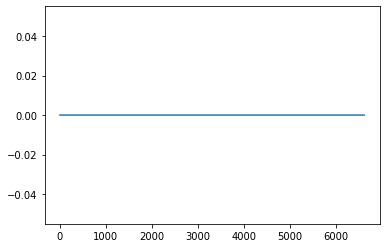

In [14]:

##expected use for the above classes:
##Assume the position detection happen at 20Hz
simulator = soundSimulator()
#This simulates for 20 secs.. might take a few minutes to finish
total_simulation_time = 0.3
simulator.simulate(total_simulation_time)
# # The rate at which position detection is performed
# dt = 0.05
# current_time = 0.0
# first_iteration_flag = True
# estimated_trajectory = []
# while (current_time <= total_simulation_time):
#     sound1, sound2 = simulator.simulatedSound(current_time,current_time+dt) #sound for 0.05 sec
#     ###perform location estimation here #####   
#     #                                       # 
#     #                                       #
#     location1 = []
#     location2 = []
#     #######################################
#     if first_iteration_flag:
#         #Initialize the Kalman filter with the first observation
#         #The initial guess should be a list with 4 elements
#         #[x,y,x_dot,y_dot]. Since do not estimate velocity, set them to be
#         #zero
#         Kalman1 = KalmanFilter(initial_guess = [location1[0],location1[1],0,0],dt)
#         Kalman2 = KalmanFilter(initial_guess = [location2[0],location2[1],0,0],dt)
#         #record the estimated trajectory for later use
#         estimated_trajectory.append(location1 + location2)
#     else:
#         #input are a list of two elements
#         estimated_location_1 = KalmanFilter.performIteration(new_observation = location1)
#         estimated_location_2 = KalmanFilter.performIteration(new_observation = location2)
#         estimated_trajectory.append(estimated_state_1 + estimated_state_2)
    


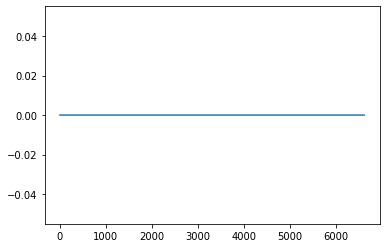

In [10]:
##use the grond truth separated signal directly for debugging...
mic1_agent1,mic1_agent2,mic2_agent1,mic2_agent2 = simulator.simulatedUnmixedSound(0.0,0.3)

plt.plot(range(len(mic1_agent1)),mic1_agent1)

In [96]:
#scipy.io.wavfile.write('output/mic1.wav',rate =self.fs ,data = self.s1)
#scipy.io.wavfile.write('output/mic1.wav',rate = 22050 ,data = np.array(simulator.mic1,dtype = "int16"))
#simulator.s1
#simulator.mic1
#simulator.mic1,22050
# print("length is",len(simulator.mic1))
# print(max(simulator.s1))
# print(max(simulator.mic1))
# print(simulator.s1[10000])
#kalman1 = KalmanFilter(initial_guess = [0,0,0,0])



In [123]:
#print(kalman1.performIteration([0.018,0.018]))

[array([0.01859686]), array([0.01859686])]
